In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
DATA_DIR = "/kaggle/input/lungcancer4types-imagedataset/Data"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")


In [ ]:
def print_class_distribution(folder, split_name):
    dataset = datasets.ImageFolder(folder)
    counts = Counter(dataset.targets)
    print(f"\n{split_name} distribution:")
    for idx, cls in enumerate(dataset.classes):
        print(f"{cls}: {counts[idx]}")

print_class_distribution(TRAIN_DIR, "Train")
print_class_distribution(VAL_DIR, "Validation")
print_class_distribution(TEST_DIR, "Test")



Train distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115
normal: 148
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155

Validation distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 23
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 21
normal: 13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 15

Test distribution:
adenocarcinoma: 120
large.cell.carcinoma: 51
normal: 54
squamous.cell.carcinoma: 90


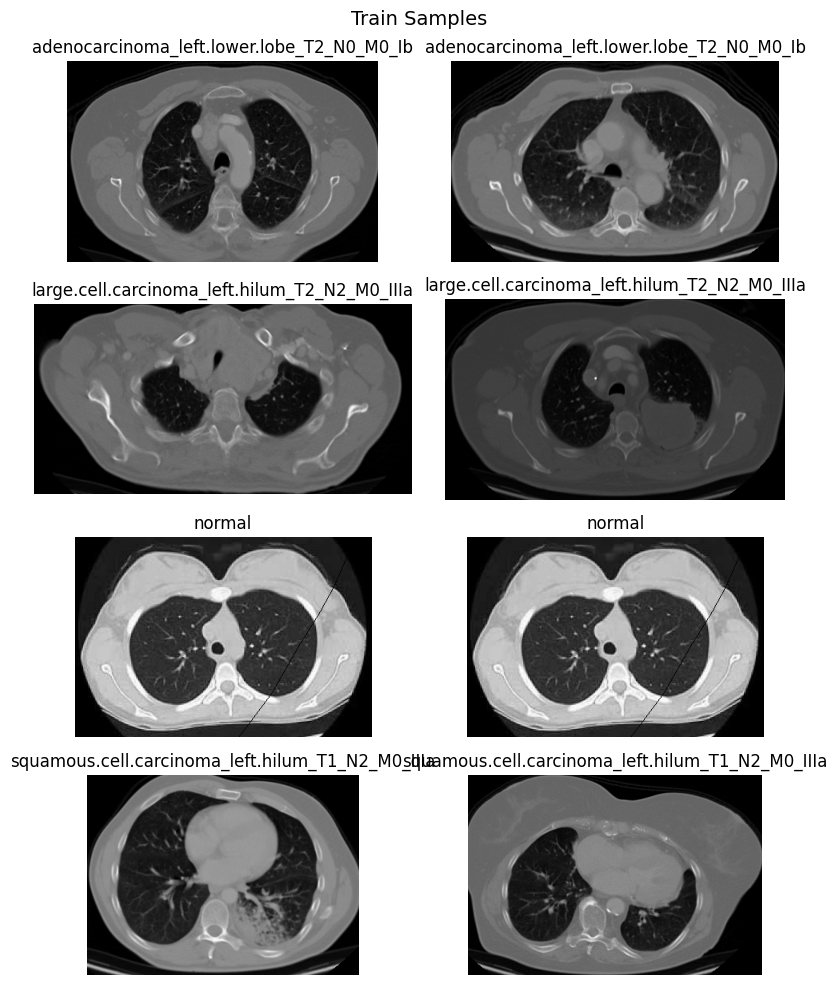

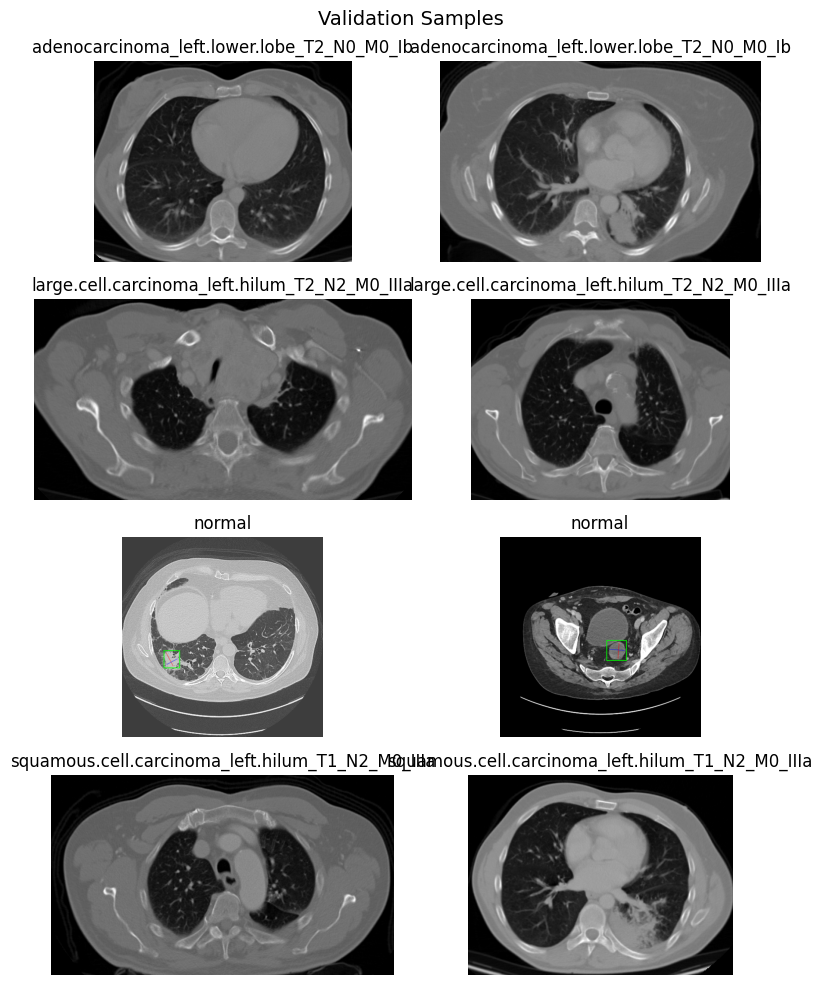

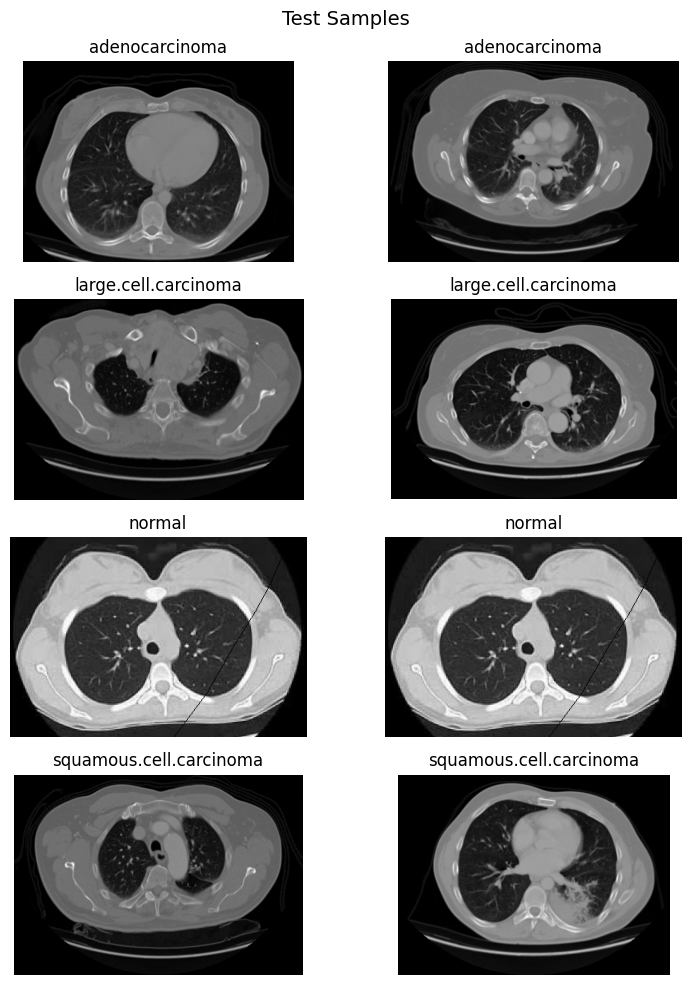

In [ ]:
def show_images(folder, title, n_per_class=2):
    dataset = datasets.ImageFolder(folder)
    class_indices = {i: [] for i in range(len(dataset.classes))}

    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < n_per_class:
            class_indices[label].append(idx)

    images = []
    labels = []

    for label, idxs in class_indices.items():
        for idx in idxs:
            img, lbl = dataset[idx]
            images.append(img)
            labels.append(dataset.classes[lbl])

    fig, axes = plt.subplots(len(dataset.classes), n_per_class, figsize=(8, 10))
    fig.suptitle(title, fontsize=14)

    for i in range(len(images)):
        ax = axes[i // n_per_class, i % n_per_class]
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_images(TRAIN_DIR, "Train Samples")
show_images(VAL_DIR, "Validation Samples")
show_images(TEST_DIR, "Test Samples")


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

NUM_CLASSES = len(train_ds.classes)
print("Classes:", train_ds.classes)


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [ ]:
from torchvision import models
import torch.nn as nn


model = models.vit_b_16(weights="IMAGENET1K_V1")


model.heads.head = nn.Linear(
    model.heads.head.in_features,
    NUM_CLASSES
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 221MB/s] 


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4

)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    matthews_corrcoef
)

from tqdm import tqdm


In [ ]:
def compute_metrics(y_true, y_pred, y_prob, num_classes):
    metrics = {}

    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["f1"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["mcc"] = matthews_corrcoef(y_true, y_pred)

    # Sensitivity = Recall
    metrics["sensitivity"] = metrics["recall"]

    # Specificity (macro)
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp + 1e-8))
    metrics["specificity"] = np.mean(specificity)

    # AUC
    try:
        metrics["auc"] = roc_auc_score(
            y_true, y_prob, multi_class="ovr"
        )
    except:
        metrics["auc"] = 0.0

    return metrics


In [ ]:
def run_epoch(model, loader, criterion, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    loop = tqdm(loader)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        total_loss += loss.item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    avg_loss = total_loss / len(loader)
    return avg_loss, np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [ ]:
EPOCHS = 30

history = {
    "train": {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]},
    "val":   {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]}
}

best_val_loss = float("inf")


for epoch in range(EPOCHS):


    train_loss, y_t, y_p, y_prob = run_epoch(
        model, train_loader, criterion, optimizer, train=True
    )
    train_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    train_metrics["loss"] = train_loss


    val_loss, y_t, y_p, y_prob = run_epoch(
        model, val_loader, criterion, train=False
    )
    val_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    val_metrics["loss"] = val_loss


    for k in history["train"]:
        history["train"][k].append(train_metrics[k])
        history["val"][k].append(val_metrics[k])


    print(f"\nTraining Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Train Metrics - loss: {train_metrics['loss']:.4f}, "
        f"accuracy: {train_metrics['accuracy']:.4f}, "
        f"precision: {train_metrics['precision']:.4f}, "
        f"recall: {train_metrics['recall']:.4f}, "
        f"f1_score: {train_metrics['f1']:.4f}, "
        f"specificity: {train_metrics['specificity']:.4f}, "
        f"sensitivity: {train_metrics['sensitivity']:.4f}, "
        f"mcc: {train_metrics['mcc']:.4f}, "
        f"auc: {train_metrics['auc']:.4f}"
    )

    print(f"Validating Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Val Metrics   - loss: {val_metrics['loss']:.4f}, "
        f"accuracy: {val_metrics['accuracy']:.4f}, "
        f"precision: {val_metrics['precision']:.4f}, "
        f"recall: {val_metrics['recall']:.4f}, "
        f"f1_score: {val_metrics['f1']:.4f}, "
        f"specificity: {val_metrics['specificity']:.4f}, "
        f"sensitivity: {val_metrics['sensitivity']:.4f}, "
        f"mcc: {val_metrics['mcc']:.4f}, "
        f"auc: {val_metrics['auc']:.4f}"
    )



100%|██████████| 5/5 [00:00<00:00,  8.27it/s]



Training Model - Epoch [1/30]
Train Metrics - loss: 1.1236, accuracy: 0.4910, precision: 0.4699, recall: 0.4775, f1_score: 0.4693, specificity: 0.8256, sensitivity: 0.4775, mcc: 0.3087, auc: 0.7347
Validating Model - Epoch [1/30]
Val Metrics   - loss: 1.2105, accuracy: 0.4722, precision: 0.3438, recall: 0.4783, f1_score: 0.3829, specificity: 0.8067, sensitivity: 0.4783, mcc: 0.3472, auc: 0.7449


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]



Training Model - Epoch [2/30]
Train Metrics - loss: 0.9634, accuracy: 0.5595, precision: 0.5237, recall: 0.5293, f1_score: 0.5032, specificity: 0.8470, sensitivity: 0.5293, mcc: 0.4034, auc: 0.7746
Validating Model - Epoch [2/30]
Val Metrics   - loss: 1.0121, accuracy: 0.5556, precision: 0.4785, recall: 0.5538, f1_score: 0.5079, specificity: 0.8391, sensitivity: 0.5538, mcc: 0.4022, auc: 0.7527


100%|██████████| 5/5 [00:00<00:00,  8.20it/s]



Training Model - Epoch [3/30]
Train Metrics - loss: 0.8887, accuracy: 0.5889, precision: 0.5692, recall: 0.5744, f1_score: 0.5586, specificity: 0.8579, sensitivity: 0.5744, mcc: 0.4461, auc: 0.8038
Validating Model - Epoch [3/30]
Val Metrics   - loss: 1.2963, accuracy: 0.4722, precision: 0.3438, recall: 0.4783, f1_score: 0.3829, specificity: 0.8067, sensitivity: 0.4783, mcc: 0.3472, auc: 0.7660


100%|██████████| 5/5 [00:00<00:00,  7.62it/s]



Training Model - Epoch [4/30]
Train Metrics - loss: 0.8343, accuracy: 0.6362, precision: 0.6827, recall: 0.6125, f1_score: 0.5853, specificity: 0.8717, sensitivity: 0.6125, mcc: 0.5316, auc: 0.8264
Validating Model - Epoch [4/30]
Val Metrics   - loss: 1.1104, accuracy: 0.4722, precision: 0.4068, recall: 0.4841, f1_score: 0.4079, specificity: 0.8087, sensitivity: 0.4841, mcc: 0.3315, auc: 0.7806


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]



Training Model - Epoch [5/30]
Train Metrics - loss: 0.7722, accuracy: 0.6525, precision: 0.6582, recall: 0.6376, f1_score: 0.6265, specificity: 0.8789, sensitivity: 0.6376, mcc: 0.5386, auc: 0.8548
Validating Model - Epoch [5/30]
Val Metrics   - loss: 1.1267, accuracy: 0.3750, precision: 0.5585, recall: 0.4429, f1_score: 0.4049, specificity: 0.7964, sensitivity: 0.4429, mcc: 0.2388, auc: 0.7348


100%|██████████| 5/5 [00:00<00:00,  8.19it/s]



Training Model - Epoch [6/30]
Train Metrics - loss: 0.7322, accuracy: 0.6639, precision: 0.6764, recall: 0.6541, f1_score: 0.6558, specificity: 0.8828, sensitivity: 0.6541, mcc: 0.5479, auc: 0.8660
Validating Model - Epoch [6/30]
Val Metrics   - loss: 1.4126, accuracy: 0.3611, precision: 0.3970, recall: 0.4557, f1_score: 0.3484, specificity: 0.7953, sensitivity: 0.4557, mcc: 0.2779, auc: 0.7265


100%|██████████| 5/5 [00:00<00:00,  7.56it/s]



Training Model - Epoch [7/30]
Train Metrics - loss: 0.7184, accuracy: 0.6721, precision: 0.6905, recall: 0.6515, f1_score: 0.6563, specificity: 0.8857, sensitivity: 0.6515, mcc: 0.5570, auc: 0.8653
Validating Model - Epoch [7/30]
Val Metrics   - loss: 1.0872, accuracy: 0.4861, precision: 0.6390, recall: 0.4960, f1_score: 0.4236, specificity: 0.8127, sensitivity: 0.4960, mcc: 0.3549, auc: 0.7575


100%|██████████| 5/5 [00:00<00:00,  8.22it/s]



Training Model - Epoch [8/30]
Train Metrics - loss: 0.7068, accuracy: 0.6998, precision: 0.7165, recall: 0.6910, f1_score: 0.6938, specificity: 0.8951, sensitivity: 0.6910, mcc: 0.5969, auc: 0.8809
Validating Model - Epoch [8/30]
Val Metrics   - loss: 0.9498, accuracy: 0.5556, precision: 0.6117, recall: 0.5592, f1_score: 0.5216, specificity: 0.8390, sensitivity: 0.5592, mcc: 0.4345, auc: 0.7977


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]



Training Model - Epoch [9/30]
Train Metrics - loss: 0.5207, accuracy: 0.7765, precision: 0.7905, recall: 0.7669, f1_score: 0.7722, specificity: 0.9219, sensitivity: 0.7669, mcc: 0.7007, auc: 0.9307
Validating Model - Epoch [9/30]
Val Metrics   - loss: 1.0648, accuracy: 0.5139, precision: 0.5958, recall: 0.5525, f1_score: 0.5507, specificity: 0.8337, sensitivity: 0.5525, mcc: 0.3577, auc: 0.7856


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]



Training Model - Epoch [10/30]
Train Metrics - loss: 0.5508, accuracy: 0.7765, precision: 0.7893, recall: 0.7701, f1_score: 0.7761, specificity: 0.9222, sensitivity: 0.7701, mcc: 0.6989, auc: 0.9222
Validating Model - Epoch [10/30]
Val Metrics   - loss: 0.9477, accuracy: 0.5278, precision: 0.5879, recall: 0.5481, f1_score: 0.5591, specificity: 0.8370, sensitivity: 0.5481, mcc: 0.3633, auc: 0.8005


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]



Training Model - Epoch [11/30]
Train Metrics - loss: 0.3892, accuracy: 0.8630, precision: 0.8778, recall: 0.8586, f1_score: 0.8654, specificity: 0.9519, sensitivity: 0.8586, mcc: 0.8163, auc: 0.9637
Validating Model - Epoch [11/30]
Val Metrics   - loss: 1.0449, accuracy: 0.5417, precision: 0.5970, recall: 0.5590, f1_score: 0.5646, specificity: 0.8412, sensitivity: 0.5590, mcc: 0.3837, auc: 0.7945


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]



Training Model - Epoch [12/30]
Train Metrics - loss: 0.3190, accuracy: 0.8793, precision: 0.8865, recall: 0.8780, f1_score: 0.8817, specificity: 0.9582, sensitivity: 0.8780, mcc: 0.8370, auc: 0.9768
Validating Model - Epoch [12/30]
Val Metrics   - loss: 1.2207, accuracy: 0.5278, precision: 0.5762, recall: 0.5365, f1_score: 0.5458, specificity: 0.8331, sensitivity: 0.5365, mcc: 0.3567, auc: 0.8081


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]



Training Model - Epoch [13/30]
Train Metrics - loss: 0.2091, accuracy: 0.9217, precision: 0.9200, recall: 0.9209, f1_score: 0.9204, specificity: 0.9737, sensitivity: 0.9209, mcc: 0.8945, auc: 0.9901
Validating Model - Epoch [13/30]
Val Metrics   - loss: 2.3871, accuracy: 0.4722, precision: 0.5485, recall: 0.4774, f1_score: 0.4567, specificity: 0.8089, sensitivity: 0.4774, mcc: 0.3146, auc: 0.7560


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]



Training Model - Epoch [14/30]
Train Metrics - loss: 0.2682, accuracy: 0.9201, precision: 0.9265, recall: 0.9192, f1_score: 0.9222, specificity: 0.9721, sensitivity: 0.9192, mcc: 0.8924, auc: 0.9821
Validating Model - Epoch [14/30]
Val Metrics   - loss: 1.4637, accuracy: 0.4583, precision: 0.5402, recall: 0.4691, f1_score: 0.4931, specificity: 0.8085, sensitivity: 0.4691, mcc: 0.2541, auc: 0.7580


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]



Training Model - Epoch [15/30]
Train Metrics - loss: 0.1759, accuracy: 0.9413, precision: 0.9397, recall: 0.9363, f1_score: 0.9379, specificity: 0.9801, sensitivity: 0.9363, mcc: 0.9208, auc: 0.9923
Validating Model - Epoch [15/30]
Val Metrics   - loss: 1.8491, accuracy: 0.5278, precision: 0.5529, recall: 0.5618, f1_score: 0.5326, specificity: 0.8352, sensitivity: 0.5618, mcc: 0.3775, auc: 0.7759


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]



Training Model - Epoch [16/30]
Train Metrics - loss: 0.0926, accuracy: 0.9706, precision: 0.9705, recall: 0.9701, f1_score: 0.9703, specificity: 0.9900, sensitivity: 0.9701, mcc: 0.9604, auc: 0.9976
Validating Model - Epoch [16/30]
Val Metrics   - loss: 1.6565, accuracy: 0.5278, precision: 0.5845, recall: 0.5618, f1_score: 0.5290, specificity: 0.8362, sensitivity: 0.5618, mcc: 0.3842, auc: 0.8041


100%|██████████| 5/5 [00:00<00:00,  8.12it/s]



Training Model - Epoch [17/30]
Train Metrics - loss: 0.1035, accuracy: 0.9641, precision: 0.9625, recall: 0.9628, f1_score: 0.9627, specificity: 0.9880, sensitivity: 0.9628, mcc: 0.9516, auc: 0.9974
Validating Model - Epoch [17/30]
Val Metrics   - loss: 2.0083, accuracy: 0.5278, precision: 0.5480, recall: 0.5422, f1_score: 0.5109, specificity: 0.8311, sensitivity: 0.5422, mcc: 0.3787, auc: 0.7536


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]



Training Model - Epoch [18/30]
Train Metrics - loss: 0.1126, accuracy: 0.9592, precision: 0.9615, recall: 0.9612, f1_score: 0.9614, specificity: 0.9859, sensitivity: 0.9612, mcc: 0.9450, auc: 0.9969
Validating Model - Epoch [18/30]
Val Metrics   - loss: 1.7899, accuracy: 0.4444, precision: 0.5019, recall: 0.5302, f1_score: 0.4711, specificity: 0.8165, sensitivity: 0.5302, mcc: 0.3129, auc: 0.7672


100%|██████████| 5/5 [00:00<00:00,  8.24it/s]



Training Model - Epoch [19/30]
Train Metrics - loss: 0.0632, accuracy: 0.9755, precision: 0.9764, recall: 0.9767, f1_score: 0.9765, specificity: 0.9916, sensitivity: 0.9767, mcc: 0.9670, auc: 0.9990
Validating Model - Epoch [19/30]
Val Metrics   - loss: 1.5089, accuracy: 0.5694, precision: 0.6325, recall: 0.5948, f1_score: 0.6002, specificity: 0.8498, sensitivity: 0.5948, mcc: 0.4223, auc: 0.7889


100%|██████████| 5/5 [00:00<00:00,  8.09it/s]



Training Model - Epoch [20/30]
Train Metrics - loss: 0.0091, accuracy: 0.9967, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9990, sensitivity: 0.9962, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [20/30]
Val Metrics   - loss: 1.8489, accuracy: 0.6111, precision: 0.6652, recall: 0.6217, f1_score: 0.6256, specificity: 0.8617, sensitivity: 0.6217, mcc: 0.4807, auc: 0.7978


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]



Training Model - Epoch [21/30]
Train Metrics - loss: 0.0043, accuracy: 0.9984, precision: 0.9984, recall: 0.9978, f1_score: 0.9981, specificity: 0.9995, sensitivity: 0.9978, mcc: 0.9978, auc: 1.0000
Validating Model - Epoch [21/30]
Val Metrics   - loss: 1.9397, accuracy: 0.5833, precision: 0.6312, recall: 0.5931, f1_score: 0.5929, specificity: 0.8517, sensitivity: 0.5931, mcc: 0.4422, auc: 0.7959


100%|██████████| 5/5 [00:00<00:00,  8.24it/s]



Training Model - Epoch [22/30]
Train Metrics - loss: 0.0046, accuracy: 0.9967, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9990, sensitivity: 0.9962, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [22/30]
Val Metrics   - loss: 1.9711, accuracy: 0.5833, precision: 0.6298, recall: 0.5941, f1_score: 0.5977, specificity: 0.8519, sensitivity: 0.5941, mcc: 0.4377, auc: 0.7935


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]



Training Model - Epoch [23/30]
Train Metrics - loss: 0.0043, accuracy: 0.9984, precision: 0.9978, recall: 0.9984, f1_score: 0.9981, specificity: 0.9995, sensitivity: 0.9984, mcc: 0.9978, auc: 1.0000
Validating Model - Epoch [23/30]
Val Metrics   - loss: 2.0043, accuracy: 0.5833, precision: 0.6390, recall: 0.5989, f1_score: 0.6024, specificity: 0.8517, sensitivity: 0.5989, mcc: 0.4410, auc: 0.7916


100%|██████████| 5/5 [00:00<00:00,  8.18it/s]



Training Model - Epoch [24/30]
Train Metrics - loss: 0.0059, accuracy: 0.9967, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9990, sensitivity: 0.9962, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [24/30]
Val Metrics   - loss: 2.0260, accuracy: 0.5833, precision: 0.6390, recall: 0.5989, f1_score: 0.6024, specificity: 0.8517, sensitivity: 0.5989, mcc: 0.4410, auc: 0.7893


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]



Training Model - Epoch [25/30]
Train Metrics - loss: 0.0037, accuracy: 0.9984, precision: 0.9984, recall: 0.9978, f1_score: 0.9981, specificity: 0.9995, sensitivity: 0.9978, mcc: 0.9978, auc: 1.0000
Validating Model - Epoch [25/30]
Val Metrics   - loss: 2.0670, accuracy: 0.5833, precision: 0.6298, recall: 0.5941, f1_score: 0.5977, specificity: 0.8519, sensitivity: 0.5941, mcc: 0.4377, auc: 0.7870


100%|██████████| 5/5 [00:00<00:00,  8.22it/s]



Training Model - Epoch [26/30]
Train Metrics - loss: 0.0050, accuracy: 0.9967, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9990, sensitivity: 0.9962, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [26/30]
Val Metrics   - loss: 2.0976, accuracy: 0.5694, precision: 0.6176, recall: 0.5833, f1_score: 0.5885, specificity: 0.8470, sensitivity: 0.5833, mcc: 0.4162, auc: 0.7861


100%|██████████| 5/5 [00:00<00:00,  8.14it/s]



Training Model - Epoch [27/30]
Train Metrics - loss: 0.0046, accuracy: 0.9984, precision: 0.9978, recall: 0.9984, f1_score: 0.9981, specificity: 0.9995, sensitivity: 0.9984, mcc: 0.9978, auc: 1.0000
Validating Model - Epoch [27/30]
Val Metrics   - loss: 2.1041, accuracy: 0.5833, precision: 0.6390, recall: 0.5989, f1_score: 0.6024, specificity: 0.8517, sensitivity: 0.5989, mcc: 0.4410, auc: 0.7866


100%|██████████| 5/5 [00:00<00:00,  8.20it/s]



Training Model - Epoch [28/30]
Train Metrics - loss: 0.0058, accuracy: 0.9984, precision: 0.9984, recall: 0.9978, f1_score: 0.9981, specificity: 0.9995, sensitivity: 0.9978, mcc: 0.9978, auc: 1.0000
Validating Model - Epoch [28/30]
Val Metrics   - loss: 2.1135, accuracy: 0.5972, precision: 0.6506, recall: 0.6108, f1_score: 0.6162, specificity: 0.8568, sensitivity: 0.6108, mcc: 0.4585, auc: 0.7859


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]



Training Model - Epoch [29/30]
Train Metrics - loss: 0.0035, accuracy: 0.9967, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9990, sensitivity: 0.9962, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [29/30]
Val Metrics   - loss: 2.1456, accuracy: 0.5833, precision: 0.6298, recall: 0.5941, f1_score: 0.5977, specificity: 0.8519, sensitivity: 0.5941, mcc: 0.4377, auc: 0.7856


100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


Training Model - Epoch [30/30]
Train Metrics - loss: 0.0039, accuracy: 0.9967, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9990, sensitivity: 0.9962, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [30/30]
Val Metrics   - loss: 2.1635, accuracy: 0.5833, precision: 0.6298, recall: 0.5941, f1_score: 0.5977, specificity: 0.8519, sensitivity: 0.5941, mcc: 0.4377, auc: 0.7859


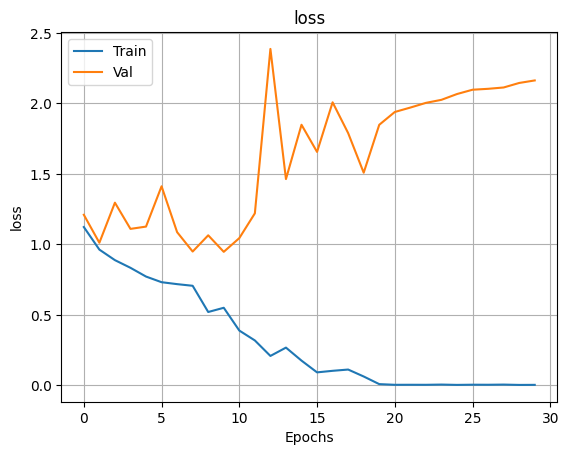

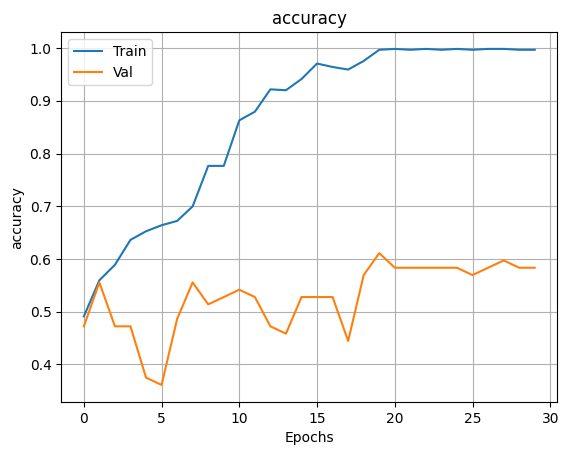

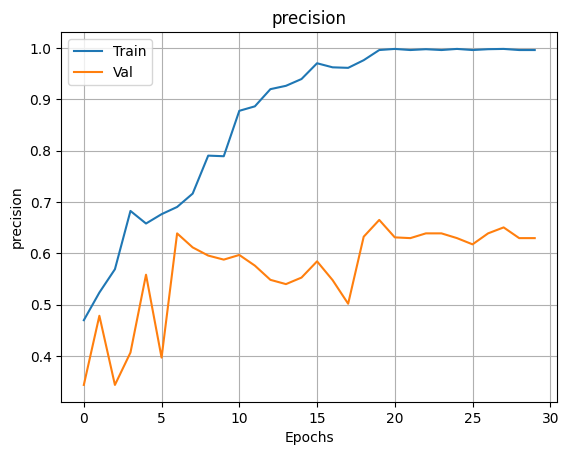

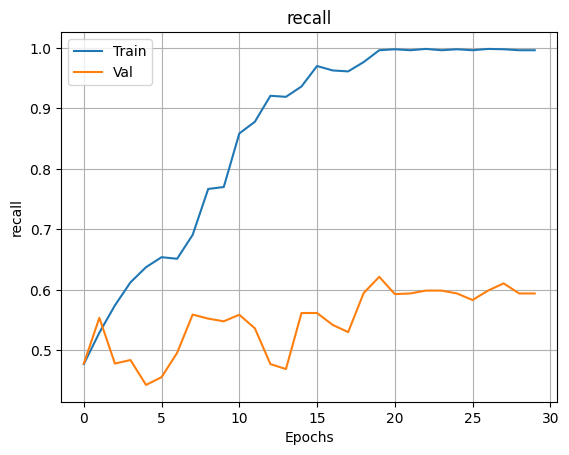

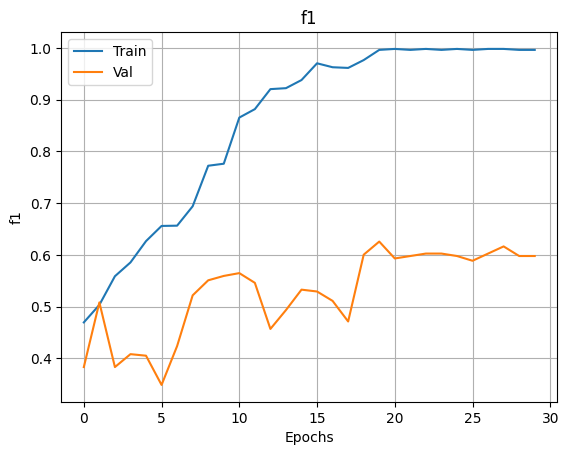

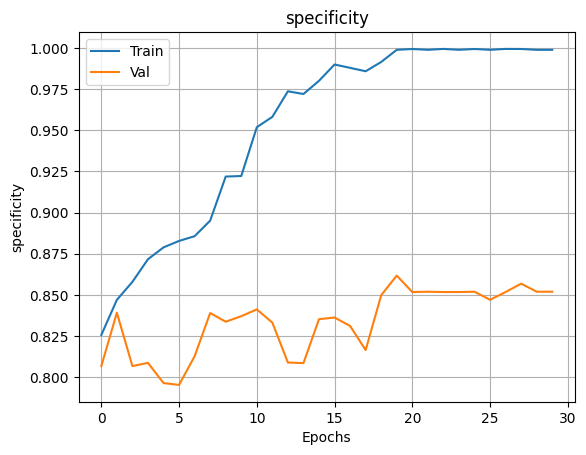

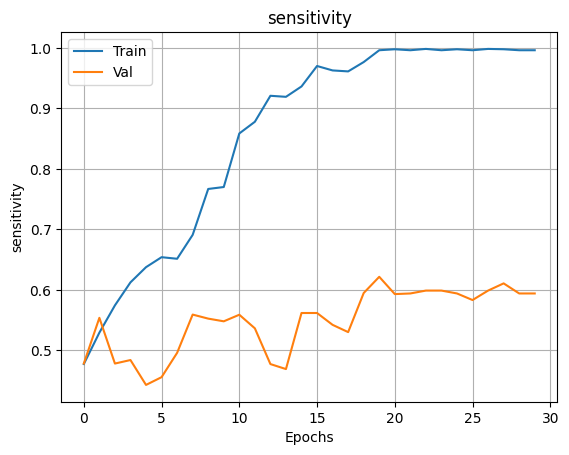

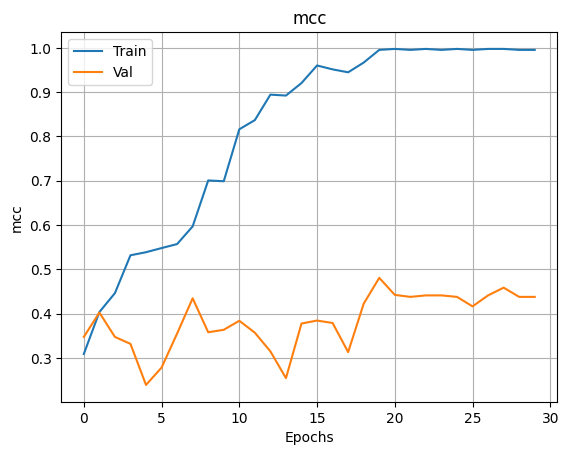

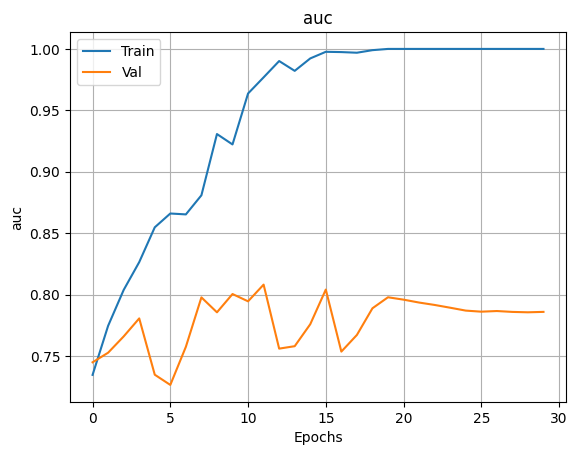

In [ ]:
def plot_metric(metric):
    plt.figure()
    plt.plot(history["train"][metric], label="Train")
    plt.plot(history["val"][metric], label="Val")
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

metrics_to_plot = [
    "loss","accuracy","precision","recall","f1",
    "specificity","sensitivity","mcc","auc"
]

for m in metrics_to_plot:
    plot_metric(m)


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.classes,digits=4))



Confusion Matrix:
 [[81 31  0  8]
 [12 33  0  6]
 [ 5  0 49  0]
 [34 12  2 42]]

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.6136    0.6750    0.6429       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.4342    0.6471    0.5197        51
                                          normal     0.9608    0.9074    0.9333        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.7500    0.4667    0.5753        90

                                        accuracy                         0.6508       315
                                       macro avg     0.6897    0.6740    0.6678       315
                                    weighted avg     0.6831    0.6508    0.6534       315



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()


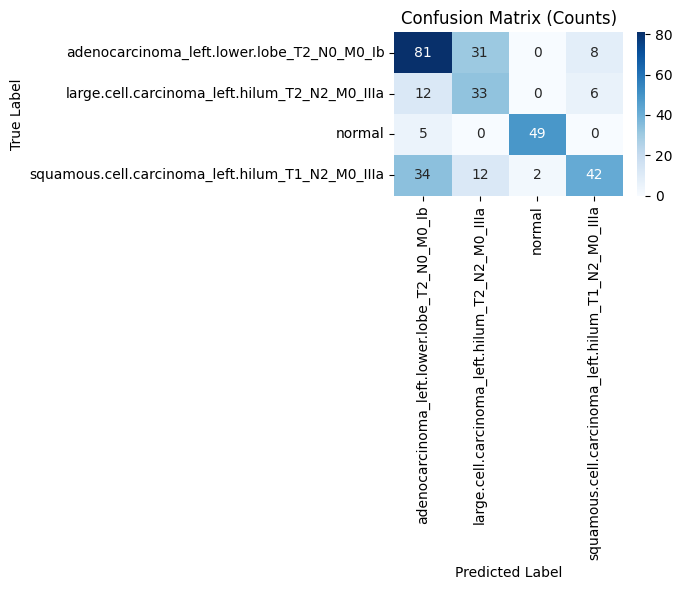

In [ ]:
plot_confusion_matrix(y_true, y_pred, train_ds.classes)


In [ ]:
from sklearn.preprocessing import label_binarize

model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

num_classes = y_prob.shape[1]
class_names = train_ds.classes


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_ovr(y_true, y_prob, class_names):
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(8, 6))

    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


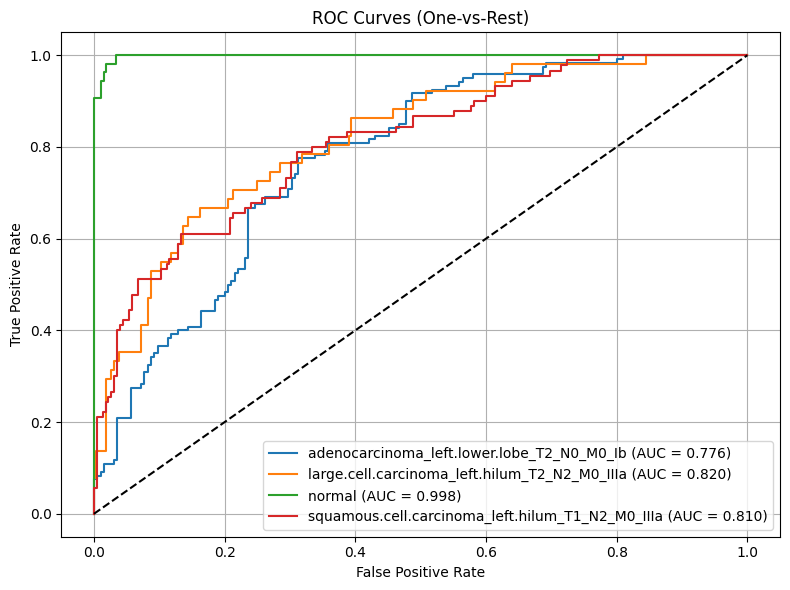

In [ ]:
plot_roc_ovr(y_true, y_prob, train_ds.classes)
